### 01. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

### 02. Second price auction class creation (Publisher perspective)

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [3]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):       #ctrs: Click to rate; advertiser's click probability
        self.ctrs = ctrs 
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids     # adv: advertiser
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

### 03. Advertiser perspective

Assumptions:

1. CTR is 1 for all advertisers
2. Stochastic Bidders: my competitors sample their bids from random uniform distributions
3. Competitors are free to exceed my budget

#### 03.01 Clarivoyant agent

In [4]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0       # Cumulative cost 
    i = 0
    while c <= B-1 and i < n_users:         # ++ Here we are assuming that the maximum bid is 1
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    clairvoyant_bids = clairvoyant_bids*m_t
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

#### 03.02 Multiplicative pacing agent

In [5]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

#### 03.03. UCB-like agent

In [6]:
class UCBBidingAgent:
    def __init__(self, valuation, budget, T, available_bids, scale=1):
        self.available_bids = available_bids
        self.discretization = available_bids.size
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.t = 0
        self.rho = self.budget/self.T
        self.avg_ft = np.zeros(self.discretization)
        self.avg_ft_UCB = np.zeros(self.discretization)
        self.avg_ct = np.zeros(self.discretization)
        self.avg_ct_LCB = np.zeros(self.discretization)
        self.gamma = np.full(self.discretization, 1/self.discretization)
        self.N = np.zeros(self.discretization)
        self.bid_t = None
        self.scale = scale
    
    def optimization_correction(self):
        gamma_equal_1_index = np.where(self.res.x == 1)       # Look up where is that "1" value
        a = self.avg_ft_UCB
        b = self.avg_ct_LCB
        bool_vector = np.logical_and(a == self.avg_ft_UCB[gamma_equal_1_index], 
                                     b == self.avg_ct_LCB[gamma_equal_1_index])  # Compare if there is other bid with the same characteristics
        self.res.x = np.where(bool_vector, 1/np.sum(bool_vector), 0)             # Share the probabilities with the bids that have the same characteristics
    
    def optimization(self):
        self.c = -self.avg_ft_UCB*self.gamma
        self.A_ub = [self.gamma*self.avg_ct_LCB]
        self.b_ub = [self.rho]
        self.A_eq = [np.ones(self.discretization)]
        self.b_eq = [1]
        self.res = optimize.linprog(self.c, A_ub=self.A_ub, b_ub=self.b_ub, A_eq=self.A_eq, b_eq=self.b_eq, bounds=(0,1))
        if np.any(self.res.x == 1):       # If there is a closed answer like [1,0,0,0], look if there is another possible optimal solution
            self.optimization_correction()
        return self.res.x
    
    def bid(self):
        if self.budget < 1:
            return 0
        
        if self.t < self.discretization:
            self.bid_t_index = self.t
        else:
            self.gamma = self.optimization()
            self.bid_t_index = np.random.choice(range(self.discretization), p= self.gamma)
            
        self.bid_t = self.available_bids[self.bid_t_index]
        return self.bid_t
    
    def update(self, f_t, c_t):
        self.N[self.bid_t_index] += 1
        self.avg_ft[self.bid_t_index] += (f_t - self.avg_ft[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ft_UCB[self.bid_t_index] = self.avg_ft[self.bid_t_index] + self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ft_UCB)
        self.avg_ct[self.bid_t_index] += (c_t - self.avg_ct[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ct_LCB[self.bid_t_index] = self.avg_ct[self.bid_t_index] - self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ct_LCB)
        self.budget -= c_t
        self.t += 1

### 04. Execution (just one instance per agent type)

#### 04.01. Clairvoyant

In [7]:
# advertisers' fixed parameters
## we assume that our agent has the FIRST index
n_advertisers = 4           # including myself
my_valuation = 0.1
B = 200
available_bids = np.linspace(0,1,60)
ctrs = np.ones(n_advertisers)   # All ctrs are 1

# environmental settings
n_users = 10000

# competitors
other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
# print(other_bids)
m_t = other_bids.max(axis=0)


# Clairvoyant bids
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)


#### 04.02. Multiplicative Pacing agent

In [33]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

# np.random.seed(20)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    # print(other_bids[:, u].ravel())
    bids = np.append(my_bid, other_bids[:, u].ravel())
    # print(bids)
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 5


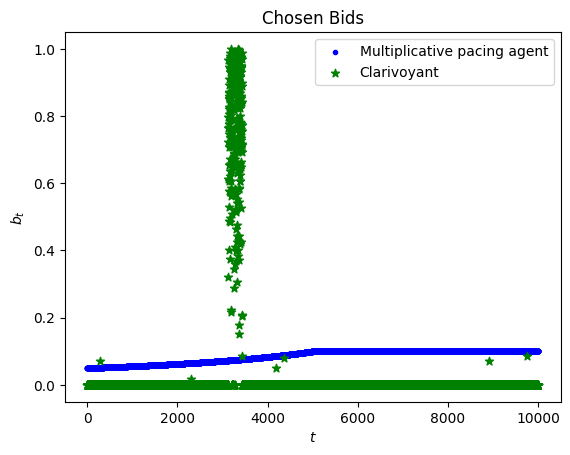

In [34]:
plt.scatter(range(n_users), my_bids, marker = ".", c= "b", label="Multiplicative pacing agent")
plt.scatter(range(n_users), clairvoyant_bids, marker = "*", c = "g", label= "Clarivoyant")
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.legend()
plt.title('Chosen Bids')
plt.show()

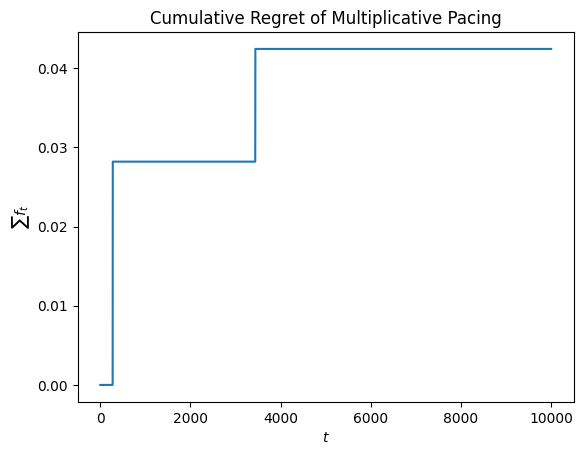

In [35]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

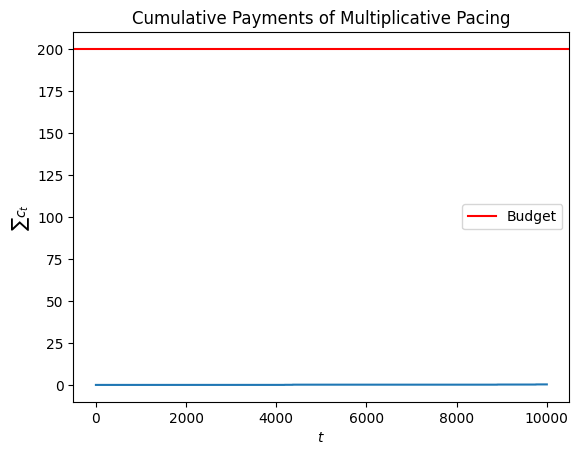

In [36]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

#### 04.03. UCB biding agent

In [28]:
agent = UCBBidingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  available_bids = available_bids,
                                  scale = 5)

auction = SecondPriceAuction(ctrs)
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0


for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    # print(my_bid, f_t, c_t, "\n", agent.gamma)
    agent.update(f_t, c_t)
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
    # print("")
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 453


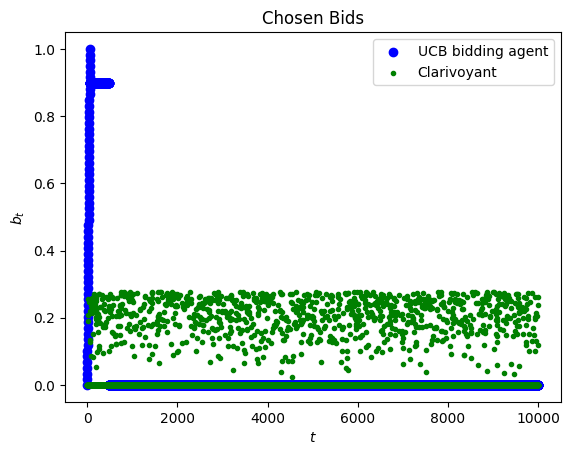

In [29]:
plt.scatter(range(n_users), my_bids, marker = "o", c= "b", label="UCB bidding agent")
plt.scatter(range(n_users), clairvoyant_bids, marker = ".", c = "g", label= "Clarivoyant")
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.legend()
plt.title('Chosen Bids')
plt.show()

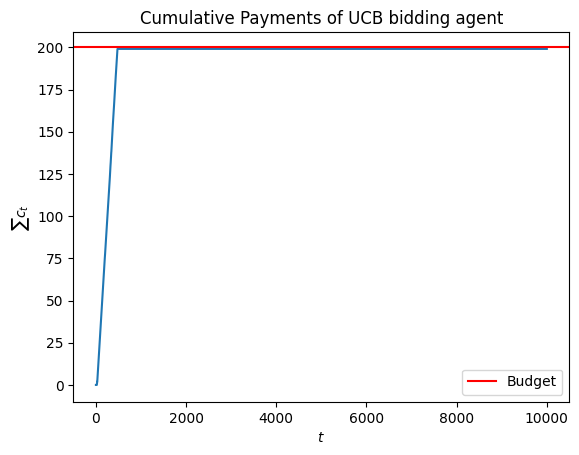

In [30]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB bidding agent')
plt.show()

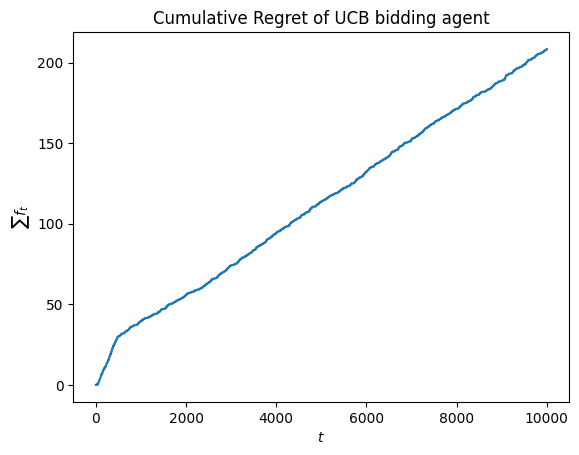

In [31]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of UCB bidding agent')
plt.show()

### 05. Generalized results (multiple instances per agent type)

#### 05.01 Parameters

In [16]:
# advertisers' fixed parameters
## we assume that our agent has the FIRST index, e.g. our q_a*v_a = 0.56
n_advertisers = 4           # including myself
my_valuation = 0.1
B = 200
eta = 1/np.sqrt(n_users) # from theory
available_bids = np.linspace(0,1,60)
ctrs = np.ones(n_advertisers)   # All ctrs are 1

# environmental settings
n_users = 10000

#### 05.02 Multiplicative pacing agent

In [17]:
n_epochs = 50
all_regrets_mpa = []
all_payments_mpa = []
all_bids_mpa = []

eta = 1/np.sqrt(n_users) # from theory

for i in range(n_epochs):
    agent = MultiplicativePacingAgent(valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    
    # competitors
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
    m_t = other_bids.max(axis=0)

    # Clairvoyant bids
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)
    
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win
    all_regrets_mpa.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments_mpa.append(np.cumsum(my_payments))
    all_bids_mpa.append(my_bids)

avg_regret_mpa = np.array(all_regrets_mpa).mean(axis=0)
std_regret_mpa = np.array(all_regrets_mpa).std(axis=0)

avg_payments_mpa = np.array(all_payments_mpa).mean(axis=0)
std_payments_mpa = np.array(all_payments_mpa).std(axis=0)

avg_bids_mpa = np.array(all_bids_mpa).mean(axis=0)
std_bids_mpa = np.array(all_bids_mpa).std(axis=0)


In [18]:
n_epochs = n_epochs
all_regrets_ucb = []
all_payments_ucb = []
all_bids_ucb = []


for i in range(n_epochs):
    agent = UCBBidingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users,
                                  available_bids = available_bids,
                                  scale = 10)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    
    # competitors
    other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users))
    m_t = other_bids.max(axis=0)


    # Clairvoyant bids
    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)
    
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        total_wins+=my_win
    all_regrets_ucb.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments_ucb.append(np.cumsum(my_payments))
    all_bids_ucb.append(my_bids)

avg_regret_ucb = np.array(all_regrets_ucb).mean(axis=0)
std_regret_ucb = np.array(all_regrets_ucb).std(axis=0)

avg_payments_ucb = np.array(all_payments_ucb).mean(axis=0)
std_payments_ucb = np.array(all_payments_ucb).std(axis=0)

avg_bids_ucb = np.array(all_bids_ucb).mean(axis=0)
std_bids_ucb = np.array(all_bids_ucb).std(axis=0)

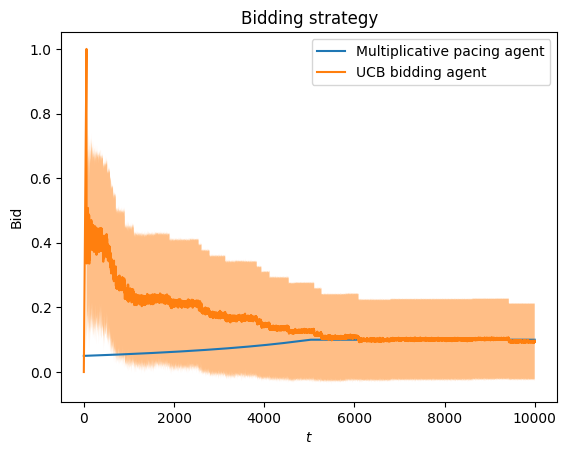

In [19]:
plt.plot(np.arange(n_users), avg_bids_mpa, label="Multiplicative pacing agent")
plt.plot(np.arange(n_users), avg_bids_ucb, label="UCB bidding agent")
plt.fill_between(np.arange(n_users), avg_bids_mpa-std_bids_mpa, avg_bids_mpa+std_bids_mpa, alpha=0.5)
plt.fill_between(np.arange(n_users), avg_bids_ucb-std_bids_ucb, avg_bids_ucb+std_bids_ucb, alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('Bid')
plt.legend()
plt.title('Bidding strategy')
plt.show()

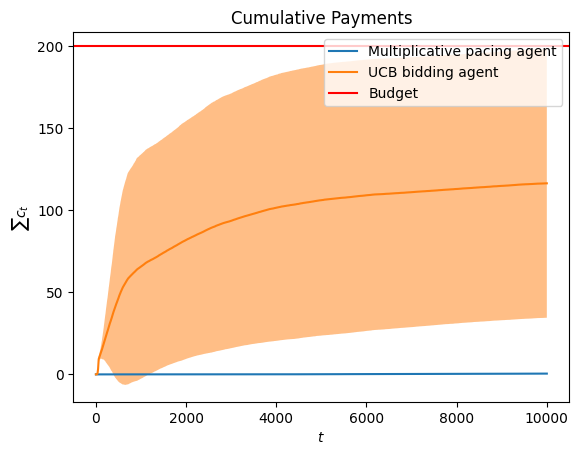

In [20]:
plt.plot(np.arange(n_users), avg_payments_mpa, label="Multiplicative pacing agent")
plt.plot(np.arange(n_users), avg_payments_ucb, label="UCB bidding agent")
plt.fill_between(np.arange(n_users), avg_payments_mpa-std_payments_mpa, avg_payments_mpa+std_payments_mpa, alpha=0.5)
plt.fill_between(np.arange(n_users), avg_payments_ucb-std_payments_ucb, avg_payments_ucb+std_payments_ucb, alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments')
plt.show()

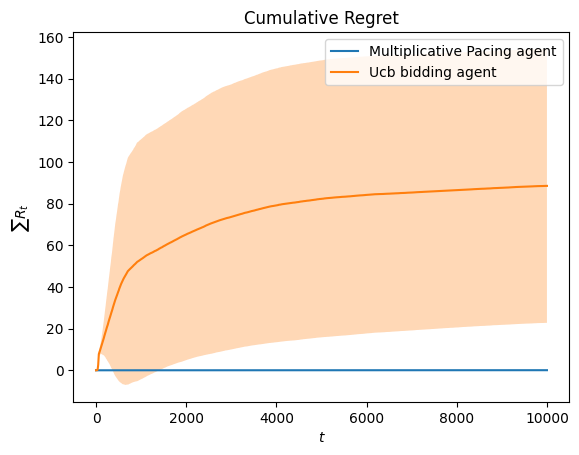

In [21]:
plt.plot(np.arange(n_users), avg_regret_mpa, label="Multiplicative Pacing agent")
plt.plot(np.arange(n_users), avg_regret_ucb, label="Ucb bidding agent")
plt.fill_between(np.arange(n_users), avg_regret_mpa-std_regret_mpa, avg_regret_mpa+std_regret_mpa, alpha=0.3)
plt.fill_between(np.arange(n_users), avg_regret_ucb-std_regret_ucb, avg_regret_ucb+std_regret_ucb, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

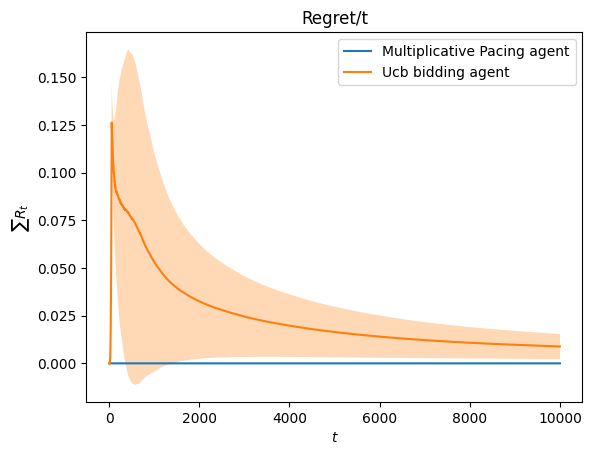

In [22]:
plt.plot(np.arange(n_users), avg_regret_mpa/range(1, n_users+1), label="Multiplicative Pacing agent")
plt.plot(np.arange(n_users), avg_regret_ucb/range(1, n_users+1), label="Ucb bidding agent")
plt.fill_between(np.arange(n_users), (avg_regret_mpa-std_regret_mpa)/range(1, n_users+1), (avg_regret_mpa+std_regret_mpa)/range(1, n_users+1), alpha=0.3)
plt.fill_between(np.arange(n_users), (avg_regret_ucb-std_regret_ucb)/range(1, n_users+1), (avg_regret_ucb+std_regret_ucb)/range(1, n_users+1), alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
# plt.ylim(0, 0.03)
plt.legend()
plt.title('Regret/t')
plt.show()

It can be seen that the UCB bidding agent reaches sublinear regret but in a really really long time